In [12]:
import pandas as pd 
import numpy as np 
import ccxt 
import time
config = open("config.txt","r")
id, secret = open("config.txt","r").readlines()[0].replace("'","").split(",")
config.close()

In [106]:
class Orderbook():
    def __init__(self,id,secret):
        self.phemex = ccxt.phemex({
        'enableRateLimit':True,
        'apiKey': id,
        'secret':secret})

    def get_orderbook_snapshot(self, symbol: str):
        ob = self.phemex.fetch_order_book(symbol)
        return ob 
    def get_ob_for_x_seconds(self, symbol:str, time_lapse: float):
        start = time.time()
        end =  time.time()
        order_book_requests = []
        while end - start < time_lapse:
            data = self.get_orderbook_snapshot(symbol)
            order_book_requests.append(data)
            end =  time.time()
        return order_book_requests
    def format_request_stream(self,ob_data):
        df = pd.DataFrame(ob_data)
        df[['bid','bid-size']] = df['bids'].apply(lambda x: x[0]).tolist()
        df[['ask','ask-size']] = df['asks'].apply(lambda x: x[0]).tolist()
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 'ms')
        df['datetime'] = pd.to_datetime(df['datetime'], infer_datetime_format= True)
        df['datetime'].dt.tz_convert("US/Eastern")
        df = df[['symbol','datetime','nonce','bid','bid-size','ask','ask-size']]
        df = df.drop_duplicates(subset=["nonce"],keep= "first")

        return df
    
    def get_level_two_ob(self,symbol:str,time_lapse: float )->pd.DataFrame:
        data = self.get_ob_for_x_seconds(symbol,time_lapse)
        data = self.format_request_stream(data)
        return data 
    
        

ob = Orderbook(id,secret)

In [116]:
data = ob.get_level_two_ob('BTC/USDT',60)

<AxesSubplot:>

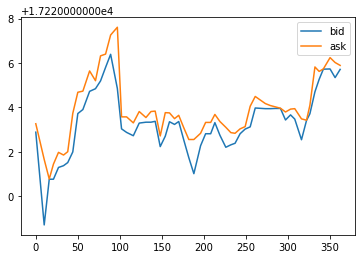

In [117]:
data[['bid','ask']].plot()

In [111]:
data['spread'] = data['ask'] - data['bid']

<AxesSubplot:>

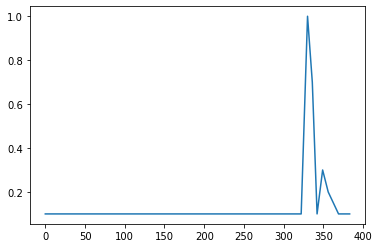

In [112]:
data['spread'].plot()

In [113]:
data

,symbol,datetime,nonce,bid,bid-size,ask,ask-size,spread
0,uBTCUSD,2022-12-09 00:14:48.205000+00:00,13562849555,17242.6,2620.0,17242.7,300.0,0.1
7,uBTCUSD,2022-12-09 00:14:49.274000+00:00,13562849769,17242.6,3780.0,17242.7,300.0,0.1
12,uBTCUSD,2022-12-09 00:14:50.056000+00:00,13562849776,17242.6,300.0,17242.7,598.0,0.1
31,uBTCUSD,2022-12-09 00:14:53.278000+00:00,13562849796,17242.6,1460.0,17242.7,598.0,0.1
37,uBTCUSD,2022-12-09 00:14:53.877000+00:00,13562849800,17242.6,300.0,17242.7,598.0,0.1
43,uBTCUSD,2022-12-09 00:14:55.031000+00:00,13562849809,17242.6,491.0,17242.7,1758.0,0.1
50,uBTCUSD,2022-12-09 00:14:56.380000+00:00,13562849829,17242.6,2811.0,17242.7,598.0,0.1
56,uBTCUSD,2022-12-09 00:14:57.378000+00:00,13562849841,17242.6,5131.0,17242.7,598.0,0.1
61,uBTCUSD,2022-12-09 00:14:58.249000+00:00,13562849849,17242.6,5711.0,17242.7,598.0,0.1
67,uBTCUSD,2022-12-09 00:14:59.102000+00:00,13562849883,17242.6,5131.0,17242.7,598.0,0.1
